In [22]:
import os
from datetime import datetime
 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [23]:
!pip install scikit-multilearn

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
#get correct directory
os.chdir('/content/drive/MyDrive/SEM 6/Love Hackathon')

In [26]:
#from .py
import utils

In [27]:
'''
https://medium.datadriveninvestor.com/a-survey-of-evaluation-metrics-for-multilabel-classification-bb16e8cd41cd
'''

'\nhttps://medium.datadriveninvestor.com/a-survey-of-evaluation-metrics-for-multilabel-classification-bb16e8cd41cd\n'

In [64]:
df_read = pd.read_csv('Demographic to Gift Preference Survey.csv')
df_read

,Timestamp,Sex,Birthday,Horoscope,Height (cm),Weight (kg),Body State,Relationship Status,Relationship Period (Starting Date),Hometown,Hobby (Select 3),Favourite Colour,Movie Preferences,Field of Work/ Study,Family Economy Status,How do you get your energy?,How do you see the world and gather information.,How do you make your decisions,How much do you plan ahead?,Gift Preferences (Choose 3)
0,2021/05/13 1:41:01 PM GMT+8,Male,1999-06-23,Cancer (Jun 21-Jul 22),170.0,72.0,Normal,Single,NaN,"Northern Region: Perlis, Kedah, Penang, Perak.",Games (board and computer games);Sports & Outd...,Blue,Action;Fantasy;Mystery;Thriller,Science,M40 (Middle 40%),I,S,T,J,Technology Gadgets;Vacation;Accompaniment (Pet...
1,2021/05/14 12:53:02 PM GMT+8,Male,2021-05-14,Pisces (Feb 19-Mar 20),175.0,63.0,Slim,In a Relationship,2019-04-01,"Northern Region: Perlis, Kedah, Penang, Perak.",Games (board and computer games);Sports & Outd...,Green,Comedy;Fantasy;Mystery,Science,M40 (Middle 40%),E,S,T,J,"Food and Snacks;Outfit (T-shirt, shoes, etc..)..."
2,2021/05/14 12:57:27 PM GMT+8,Male,1999-03-31,Aries (Mar 21-Apr 19),158.0,64.0,Slightly overweight,Single,NaN,"Northern Region: Perlis, Kedah, Penang, Perak.",Games (board and computer games);Model & Elect...,Blue,Comedy;Horror;Mystery;Thriller,Science,B40 (Bottom 40%),I,N,T,P,"Technology Gadgets;Cosmetics (Lipstick, perfum..."
3,2021/05/14 12:58:11 PM GMT+8,Female,1999-10-30,Scorpio (Oct 23-Nov 21),150.0,40.0,Normal,Single,NaN,"Southern Region: Negeri Sembilan, Malacca, Johor.","Arts & Crafts (embroidery, knitting, drawing);...",Blue,Action;Comedy;Drama;Fantasy;Mystery;Romance,Science,B40 (Bottom 40%),I,S,T,J,Technology Gadgets;Hand Made Gift (handmade ph...
4,2021/05/14 12:58:45 PM GMT+8,Female,1999-04-08,Aries (Mar 21-Apr 19),160.0,50.0,Slim,In a Relationship,2019-11-01,"Central Region: Selangor, federal territories ...","Arts & Crafts (embroidery, knitting, drawing);...",Red,Comedy;Drama;Romance,Science,M40 (Middle 40%),I,N,T,P,"Technology Gadgets;Outfit (T-shirt, shoes, etc..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2021/05/27 7:11:51 AM GMT+8,Female,1999-08-13,Leo (July 23-Aug 22),170.0,58.0,Normal,In a Relationship,2019-08-08,"Northern Region: Perlis, Kedah, Penang, Perak.","Arts & Crafts (embroidery, knitting, drawing);...",Blue,Action;Drama;Mystery,Art,B40 (Bottom 40%),I,N,T,J,Food and Snacks;Hand Made Gift (handmade photo...
126,2021/05/27 9:21:41 AM GMT+8,Male,1999-07-18,Cancer (Jun 21-Jul 22),175.0,54.0,Slim,Single,NaN,"Central Region: Selangor, federal territories ...","Arts & Crafts (embroidery, knitting, drawing);...",Blue,Drama,Art,B40 (Bottom 40%),I,N,T,J,"Food and Snacks;Cosmetics (Lipstick, perfumes,..."
127,2021/05/27 9:46:39 AM GMT+8,Male,2021-11-04,Scorpio (Oct 23-Nov 21),173.0,56.0,Normal,In a Relationship,2019-02-12,"Northern Region: Perlis, Kedah, Penang, Perak.",Games (board and computer games);Model & Elect...,Blue,Action;Fantasy;Horror,Science,M40 (Middle 40%),I,S,T,J,"Cosmetics (Lipstick, perfumes, etc..);Jewelry ..."
128,2021/05/27 10:01:34 AM GMT+8,Female,2001-05-26,Gemini (May 21-Jun 20),153.0,50.0,Normal,In a Relationship,2019-10-04,"Northern Region: Perlis, Kedah, Penang, Perak.","Collecting (stamps, coins);Arts & Crafts (embr...",Black,Action;Comedy;Romance,Science,M40 (Middle 40%),I,S,T,J,Food and Snacks;Flower;Vacation


In [28]:
#read df
df = pd.read_csv('Demographic to Gift Preference Survey.csv')

#convert to correct dtypes
df['Birthday'] = df['Birthday'].apply(lambda _: datetime.strptime(_,"%Y-%m-%d"))

#create necessary columns
df['Age'] = datetime.now().year - df['Birthday'].apply(lambda x: x.year)

#remove outliers
df['Age'] = df['Age'].apply(lambda x: x if (x >18 and x <60) else df['Age'].median()) #use median to impute age

#remove unnecessary columns
df = df.drop(['Timestamp', 'Birthday', 'Relationship Period (Starting Date)'], axis=1)

#rename for readability
df.rename(columns={'Hobby (Select 3)': 'Hobby', 'Gift Preferences (Choose 3)': 'Gift Preferences'}, inplace=True)

#Handle single feature with multiple values through one-hot encoding
multi_val_cols = ['Hobby', 'Movie Preferences', 'Gift Preferences']
new_df = utils.multi_cat_val_handler(df, multi_val_cols)
new_df = pd.get_dummies(new_df, drop_first=True)

#remove weird col
new_df.drop(['g_A smile HAHAHAHA'], axis=1, inplace=True)
new_df.drop(['g_I would choose all'], axis=1, inplace=True)
new_df.drop(['g_Not necessarily'], axis=1, inplace=True)

#remove NAN in movie - NAN means they don't like all movie 
for col in new_df.columns:
  if col.startswith('m_'):
    new_df[col] = new_df[col].fillna(0)

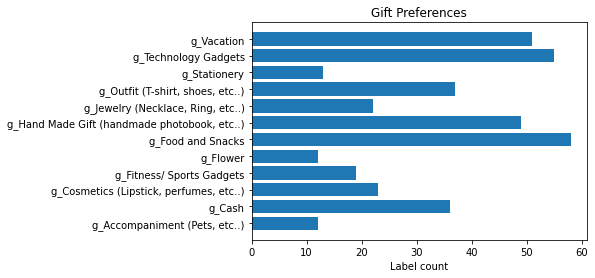

In [29]:
def get_count_val(df):
    col_list = df.columns
    col_val = []
    for col in df.columns:
        col_val.append( df[col].value_counts()[1])

    plt.barh(col_list, col_val)
    plt.title('Gift Preferences')
    plt.xlabel('Label count')
    plt.show()
    
mask = new_df.columns.str.contains(r'g_.*')
get_count_val(new_df.iloc[:, mask])

In [30]:
new_df.describe()

,Height (cm),Weight (kg),Age,"h_Arts & Crafts (embroidery, knitting, drawing)","h_Collecting (stamps, coins)",h_Games (board and computer games),"h_Model & Electronic (tinkering electronics, cars)",h_Music (performing or listening),"h_Performing Arts (drawing, sculpting, cooking)","h_Spiritual and Mental (meditation, self-enrichment sessions)",h_Sports & Outdoors (e-sports doesn't count),m_Action,m_Comedy,m_Drama,m_Fantasy,m_Horror,m_Mystery,m_Romance,m_Thriller,m_Western,"g_Accompaniment (Pets, etc..)",g_Cash,"g_Cosmetics (Lipstick, perfumes, etc..)",g_Fitness/ Sports Gadgets,g_Flower,g_Food and Snacks,"g_Hand Made Gift (handmade photobook, etc..)","g_Jewelry (Necklace, Ring, etc..)","g_Outfit (T-shirt, shoes, etc..)",g_Stationery,g_Technology Gadgets,g_Vacation,Sex_Male,Horoscope_Aries (Mar 21-Apr 19),Horoscope_Cancer (Jun 21-Jul 22),Horoscope_Capricorn (Dec 22-Jan 19),Horoscope_Gemini (May 21-Jun 20),Horoscope_Leo (July 23-Aug 22),Horoscope_Libra (Sep 23-Oct 22),Horoscope_Pisces (Feb 19-Mar 20),Horoscope_Sagittarius (Nov 22-Dec 21),Horoscope_Scorpio (Oct 23-Nov 21),Horoscope_Taurus (Apr 20-May 20),Horoscope_Virgo (Aug 23-Sep 22),Body State_Fat,Body State_Fat,Body State_Lean,Body State_Muscular,Body State_Normal,Body State_Not slim,Body State_Slightly overweight,Body State_Slim,Relationship Status_Married,Relationship Status_Single,"Hometown _East Coast Region: Kelantan, Terengganu, Pahang,","Hometown _East Malaysia: Sabah, Sarawak","Hometown _Northern Region: Perlis, Kedah, Penang, Perak.",Hometown _Others,"Hometown _Southern Region: Negeri Sembilan, Malacca, Johor.",Favourite Colour_Blue,Favourite Colour_Green,Favourite Colour_Indigo,Favourite Colour_Orange,Favourite Colour_Purple,Favourite Colour_Red,Favourite Colour_White,Favourite Colour_Yellow,Field of Work/ Study_Science,Family Economy Status_M40 (Middle 40%),Family Economy Status_T20 (Top 20%),How do you get your energy?_I,How do you see the world and gather information. _S,How do you make your decisions_T,How much do you plan ahead?_P
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.00000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,164.173077,55.828462,22.115385,0.346154,0.053846,0.530769,0.115385,0.769231,0.338462,0.253846,0.592308,0.561538,0.692308,0.507692,0.369231,0.292308,0.500000,0.484615,0.261538,0.192308,0.092308,0.276923,0.176923,0.146154,0.092308,0.446154,0.376923,0.169231,0.284615,0.100000,0.423077,0.392308,0.438462,0.084615,0.123077,0.069231,0.076923,0.069231,0.046154,0.046154,0.053846,0.153846,0.115385,0.076923,0.007692,0.007692,0.007692,0.038462,0.707692,0.007692,0.007692,0.207692,0.007692,0.761538,0.169231,0.030769,0.507692,0.015385,0.161538,0.30000,0.053846,0.015385,0.015385,0.161538,0.069231,0.138462,0.053846,0.676923,0.592308,0.061538,0.707692,0.630769,0.584615,0.476923
std,8.028223,10.743567,1.090015,0.477583,0.226587,0.500983,0.320721,0.422955,0.475017,0.436894,0.493306,0.498118,0.463324,0.501875,0.484463,0.456582,0.501934,0.501697,0.441173,0.395638,0.290580,0.449209,0.383080,0.354627,0.290580,0.499015,0.486490,0.376406,0.452977,0.301161,0.495959,0.490153,0.498118,0.279385,0.329796,0.254828,0.267500,0.254828,0.210630,0.210630,0.226587,0.362197,0.320721,0.267500,0.087706,0.087706,0.087706,0.193052,0.456582,0.087706,0.087706,0.407225,0.0

In [31]:
utils.check_df(new_df, show_unique=True)

No null exist in this dataframe.


# Train & Test Datasets

In [61]:
mask = new_df.columns.str.contains(r'g_.*')
y = new_df.iloc[:, mask]
X_master = new_df.drop(y.columns, axis=1)

corr_df = pd.concat([X_master,y],axis=1)
corr = corr_df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

corr_v1 = corr.iloc[-12:, :-12]
column_master = corr_v1.columns
columns_select = np.full(len(column_master), False, dtype=bool)

'''
columnName = corrent column name
columnData = series of the column
Idea: To loop through each columns and remove the columns if all are negative
'''
selection_threshold = 0.15

for index, (columnName, columnData) in enumerate(corr_v1.iteritems()):
    for s in columnData:
        flag = False
        if s > selection_threshold:
            flag =True
            break
    if flag == True:
        columns_select[index] = True

columns_select_converted = corr_v1.columns[columns_select]

In [63]:
# corr_v1[columns_select_converted]
corr = corr_df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [34]:
# from sklearn.decomposition import PCA
# mask = new_df.columns.str.contains(r'g_.*')
# y = new_df.iloc[:, mask]
# X_master = new_df.drop(y.columns, axis=1)
# #only select columns from after filtering using correlation
# X = X_master[columns_select_converted]

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)
# y = y.to_numpy()

# #test PCA
# pca = PCA(n_components=20)
# principalComponents = pca.fit_transform(X)
# principalDf = pd.DataFrame(data = principalComponents)

# X_train, X_test, y_train, y_test = train_test_split(principalDf, y, test_size=0.20, random_state=42)
X, y, X_train, X_test, y_train, y_test = utils.get_dataset()

In [35]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=35)
# pca.fit(X)
# X = pca.transform(X)

In [36]:
'''
'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
'''

"\n'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.\n'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.\n'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.\n"

In [37]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

def cross_validate_models(models, X, y):
    '''
    cross_validate and return the best model.
    '''
    features = ['Models',
                'test_f1_macro_mean', 'test_f1_macro_std', 'train_f1_macro_mean', 'train_f1_macro_std',
                'test_f1_weighted_mean', 'test_f1_weighted_std', 'train_f1_weighted_mean', 'train_f1_weighted_std',
                'test_f1_micro_mean', 'test_f1_micro_std', 'train_f1_micro_mean', 'train_f1_micro_std',
                'test_recall_weighted_mean', 'test_recall_weighted_std', 'train_recall_weighted_mean', 'train_recall_weighted_std',
                'test_recall_macro_mean', 'test_recall_macro_std', 'train_recall_macro_mean', 'train_recall_macro_std',
                'test_recall_micro_mean', 'test_recall_micro_std', 'train_recall_micro_mean', 'train_recall_micro_std',
                'test_precision_weighted_mean', 'test_precision_weighted_std', 'train_precision_weighted_mean', 'train_precision_weighted_std', 
                'test_precision_macro_mean', 'test_precision_macro_std', 'train_precision_macro_mean', 'train_precision_macro_std', 
                'test_precision_micro_mean', 'test_precision_micro_std', 'train_precision_micro_mean', 'train_precision_micro_std', 
                ]
                
    scoring =['f1_weighted', 'f1_macro', 'f1_micro', 
              'recall_weighted', 'recall_macro', 'recall_micro',
              'precision_weighted', 'precision_macro', 'precision_micro']
    
    df = pd.DataFrame(columns = features) 

    best_f1_macro_mean = 0
    best_model = None

    for index, model in enumerate(models):
        #drop all columns that has NAN
#             X = df_32_X.drop(col, axis=1)
        rkf = RepeatedKFold(n_splits=5, n_repeats=15, random_state=42) #since dataset is low, cv=~5 (5 folds) and repeat 15 times
        cv = cross_validate(model, X, y, cv=rkf, return_train_score=True, scoring=scoring)

        info = pd.Series({'Models':model, 
                          
                          'test_f1_macro_mean':cv['test_f1_macro'].mean(), 'test_f1_macro_std':cv['test_f1_macro'].std(), 
                          'train_f1_macro_mean':cv['train_f1_macro'].mean(), 'train_f1_macro_std':cv['train_f1_macro'].std(),

                          'test_f1_weighted_mean':cv['test_f1_weighted'].mean(), 'test_f1_weighted_std':cv['test_f1_weighted'].std(), 
                          'train_f1_weighted_mean':cv['train_f1_weighted'].mean(), 'train_f1_weighted_std':cv['train_f1_weighted'].std(),

                          'test_f1_micro_mean':cv['test_f1_micro'].mean(), 'test_f1_micro_std':cv['test_f1_micro'].std(), 
                          'train_f1_micro_mean':cv['train_f1_micro'].mean(), 'train_f1_micro_std':cv['train_f1_micro'].std(),

                          'test_recall_weighted_mean':cv['test_recall_weighted'].mean(), 'test_recall_weighted_std':cv['test_recall_weighted'].std(), 
                          'train_recall_weighted_mean':cv['train_recall_weighted'].mean(), 'train_recall_weighted_std':cv['train_recall_weighted'].std(),

                          'test_recall_macro_mean':cv['test_recall_macro'].mean(), 'test_recall_macro_std':cv['test_recall_macro'].std(), 
                          'train_recall_macro_mean':cv['train_recall_macro'].mean(), 'train_recall_macro_std':cv['train_recall_macro'].std(),

                          'test_recall_micro_mean':cv['test_recall_micro'].mean(), 'test_recall_micro_std':cv['test_recall_micro'].std(), 
                          'train_recall_micro_mean':cv['train_recall_micro'].mean(), 'train_recall_micro_std':cv['train_recall_micro'].std(),

                          'test_precision_weighted_mean':cv['test_precision_weighted'].mean(), 'test_precision_weighted_std':cv['test_precision_weighted'].std(), 
                          'train_precision_weighted_mean':cv['train_precision_weighted'].mean(), 'train_precision_weighted_std':cv['train_precision_weighted'].std(),

                          'test_precision_macro_mean':cv['test_precision_macro'].mean(), 'test_precision_macro_std':cv['test_precision_macro'].std(), 
                          'train_precision_macro_mean':cv['train_precision_macro'].mean(), 'train_precision_macro_std':cv['train_precision_macro'].std(),

                          'test_precision_micro_mean':cv['test_precision_micro'].mean(), 'test_precision_micro_std':cv['test_precision_micro'].std(), 
                          'train_precision_micro_mean':cv['train_precision_micro'].mean(), 'train_precision_micro_std':cv['train_precision_micro'].std(),                          

                         })
                     
        df.loc[index] = info

        if best_f1_macro_mean < cv['test_f1_macro'].mean():
            best_f1_macro_mean = cv['test_f1_macro'].mean()
            best_model = model
    
    print(f'Cross validation Result for {col}:')
    display(df)
    print(f'The best model is \n {best_model} \n with f1_macro score: {best_f1_macro_mean}')
    return df, best_model, best_f1_macro_mean

In [38]:
'''
tree.DecisionTreeClassifier
tree.ExtraTreeClassifier
ensemble.ExtraTreesClassifier
neighbors.KNeighborsClassifier
neural_network.MLPClassifier
neighbors.RadiusNeighborsClassifier
ensemble.RandomForestClassifier
linear_model.RidgeClassifierCV
'''

scoring = ['f1_weighted', 'f1_macro', 'f1_micro', 
           'recall_weighted', 'recall_macro', 'recall_micro',
           'precision_weighted', 'precision_macro', 'precision_micro']

In [39]:
import warnings
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')

In [55]:
#Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.semi_supervised import LabelSpreading

dt_clf = DecisionTreeClassifier(random_state=0)
et_clf = ExtraTreeClassifier(random_state=0)
ets_clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
knn_clf = KNeighborsClassifier(n_neighbors=16)
mlp1_clf = MLPClassifier(hidden_layer_sizes=(80,54,12), activation = 'identity',solver='adam', alpha=0.05, learning_rate='constant' ,random_state=1, max_iter=5000)
mlp_clf = MLPClassifier(hidden_layer_sizes=(54,48), activation = 'identity',solver='adam', random_state=1, max_iter=5000)
rdm_f_clf = RandomForestClassifier(n_estimators=1, criterion='entropy', random_state=12)

svm = SVC(C=1.8, kernel="rbf",probability=True)
svm_clf = MultiOutputClassifier(svm, n_jobs=-1)

clf1_1 = BinaryRelevance(GaussianNB())
clf1_2 = BinaryRelevance(LogisticRegression())
clf1_3 = BinaryRelevance(RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]))
clf1_4 = BinaryRelevance(RidgeClassifier())
clf1_5 = BinaryRelevance(RadiusNeighborsClassifier(radius=10.0))
clf1_6 = BinaryRelevance(QuadraticDiscriminantAnalysis())
clf1_7 = BinaryRelevance(NearestCentroid())
clf1_8 = BinaryRelevance(LogisticRegressionCV(cv=5, random_state=0))
clf1_9 = BinaryRelevance(make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5)))
clf1_10 = BinaryRelevance(LinearDiscriminantAnalysis())

clf2_1 = ClassifierChain(GaussianNB())
clf2_2 = ClassifierChain(LogisticRegression())
clf2_3 = ClassifierChain(RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]))
clf2_4 = ClassifierChain(RidgeClassifier())
clf2_5 = ClassifierChain(RadiusNeighborsClassifier(radius=10.0))
clf2_6 = ClassifierChain(QuadraticDiscriminantAnalysis())
clf2_7 = ClassifierChain(NearestCentroid())
clf2_8 = ClassifierChain(LogisticRegressionCV(cv=5, random_state=0))
clf2_9 = ClassifierChain(make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5)))
clf2_10 = ClassifierChain(LinearDiscriminantAnalysis())

clf3_1 = LabelPowerset(GaussianNB())
clf3_2 = LabelPowerset(LogisticRegression())
clf3_3 = LabelPowerset(RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]))
clf3_4 = LabelPowerset(RidgeClassifier())
clf3_5 = LabelPowerset(RadiusNeighborsClassifier(radius=10.0))
clf3_6 = LabelPowerset(QuadraticDiscriminantAnalysis())
clf3_7 = LabelPowerset(NearestCentroid())
clf3_8 = LabelPowerset(LogisticRegressionCV(cv=5, random_state=0))
clf3_9 = LabelPowerset(make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5)))
clf3_10 = LabelPowerset(LinearDiscriminantAnalysis())


In [56]:
models = [mlp_clf, mlp1_clf, svm_clf, dt_clf, et_clf, ets_clf, knn_clf, rdm_f_clf,
          clf1_1,clf1_2,clf1_3,clf1_4,clf1_5,clf1_6,clf1_7,clf1_8,clf1_9,clf1_10,
          clf2_1,clf2_2,clf2_3,clf2_4,clf2_5,clf2_6,clf2_7,clf2_8,clf2_9,clf2_10,
          clf3_1,clf3_2,clf3_3,clf3_4,clf3_5,clf3_6,clf3_7,clf3_8,clf3_9,clf3_10]

score_df, best_model, best_f1_macro_mean = cross_validate_models(models, X, y)


Cross validation Result for How much do you plan ahead?_P:


,Models,test_f1_macro_mean,test_f1_macro_std,train_f1_macro_mean,train_f1_macro_std,test_f1_weighted_mean,test_f1_weighted_std,train_f1_weighted_mean,train_f1_weighted_std,test_f1_micro_mean,test_f1_micro_std,train_f1_micro_mean,train_f1_micro_std,test_recall_weighted_mean,test_recall_weighted_std,train_recall_weighted_mean,train_recall_weighted_std,test_recall_macro_mean,test_recall_macro_std,train_recall_macro_mean,train_recall_macro_std,test_recall_micro_mean,test_recall_micro_std,train_recall_micro_mean,train_recall_micro_std,test_precision_weighted_mean,test_precision_weighted_std,train_precision_weighted_mean,train_precision_weighted_std,test_precision_macro_mean,test_precision_macro_std,train_precision_macro_mean,train_precision_macro_std,test_precision_micro_mean,test_precision_micro_std,train_precision_micro_mean,train_precision_micro_std
0,"MLPClassifier(activation='identity', alpha=0.0...",0.317257,0.046488,0.979598,0.011431,0.400611,0.047231,0.968340,0.016921,0.395426,0.043777,0.968819,0.016636,0.418810,0.054102,0.965844,0.018998,0.355846,0.066022,0.977900,0.012789,0.418810,0.054102,0.965844,0.018998,0.413466,0.051684,0.971274,0.015635,0.317286,0.042998,0.981586,0.010511,0.375593,0.039512,0.971862,0.015442
1,"MLPClassifier(activation='identity', alpha=0.0...",0.316598,0.047902,0.978065,0.011185,0.403189,0.047988,0.965961,0.016412,0.394956,0.044555,0.966453,0.016016,0.423836,0.055184,0.964274,0.019057,0.359525,0.069524,0.976824,0.012874,0.423836,0.055184,0.964274,0.019057,0.412862,0.050189,0.968266,0.015361,0.311515,0.043031,0.979715,0.010405,0.370795,0.039854,0.968731,0.015273
2,"MultiOutputClassifier(estimator=SVC(C=1.8, bre...",0.147596,0.027181,0.874970,0.022960,0.242005,0.044143,0.915497,0.013117,0.300209,0.047618,0.921634,0.011576,0.217101,0.037301,0.860918,0.019780,0.135298,0.024582,0.797578,0.030904,0.217101,0.037301,0.860918,0.019780,0.322009,0.075595,0.992872,0.003875,0.192897,0.045578,0.995962,0.002205,0.491347,0.079108,0.991850,0.004466
3,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.247258,0.039707,1.000000,0.000000,0.330633,0.041348,1.000000,0.000000,0.332998,0.039692,1.000000,0.000000,0.332998,0.039692,1.000000,0.000000,0.264276,0.046599,1.000000,0.000000,0.332998,0.039692,1.000000,0.000000,0.360636,0.053626,1.000000,0.000000,0.261993,0.048133,1.000000,0.000000,0.332998,0.039692,1.000000,0.000000
4,"ExtraTreeClassifier(ccp_alpha=0.0, class_weigh...",0.247245,0.042033,1.000000,0.000000,0.333013,0.046451,1.000000,0.000000,0.335692,0.042964,1.000000,0.000000,0.335692,0.042964,1.000000,0.000000,0.261595,0.044384,1.000000,0.000000,0.335692,0.042964,1.000000,0.000000,0.358005,0.056811,1.000000,0.000000,0.259823,0.051384,1.000000,0.000000,0.335692,0.042964,1.000000,0.000000
5,"ExtraTreesClassifier(bootstrap=False, ccp_alph...",0.132522,0.024403,1.000000,0.000000,0.215066,0.040343,1.000000,0.000000,0.262622,0.046671,1.000000,0.000000,0.181108,0.035176,1.000000,0.000000,0.113711,0.022940,1.000000,0.000000,0.181108,0.035176,1.000000,0.000000,0.323589,0.081839,1.000000,0.000000,0.195401,0.047603,1.000000,0.000000,0.486614,0.091053,1.000000,0.000000
6,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.106272,0.021126,0.141781,0.014163,0.179679,0.042439,0.238853,0.025437,0.237914,0.049823,0.303972,0.030627,0.153621,0.034750,0.196316,0.024045,0.092883,0.019954,0.115434,0.012596,0.153621,0.034750,0.196316,0.024045,0.293793,0.096554,0.391208,0.046329,0.169481,0.049378,0.242774,0.036488,0.540153,0.112495,0.679239,0.037081
7,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.246692,0.047495,0.720511,0.015448,0.323076,0.049163,0.748776,0.011727,0.324875,0.051372,0.749174,0.011675,0.324875,0.051372,0.749174,0.011675,0.265547,0.059389,0.720464,0.017256,0.324875,0.051372,0.749174,0.011675,0.352996,0.059052,0.759728,0.012359,0.261448,0.055103,0.738004,0.021386,0.324875,0.051372,0.749174,0.011675
8,BinaryRelevance(classifier=GaussianNB(priors=N...,0.356435,0.028872,0.513862,0.019645,0.447853,0.041383,0.559218,0

The best model is 
 BinaryRelevance(classifier=GaussianNB(priors=None, var_smoothing=1e-09),
                require_dense=[True, True]) 
 with f1_macro score: 0.356434531770311


In [58]:
score_df.to_excel('validation_report.xlsx', sheet_name = 'New_sheet',index=False)

In [59]:
def imp_scores(df_score):
    return df_score[['Models','test_f1_macro_mean', 'train_f1_macro_mean']]

In [60]:
df_new = imp_scores(score_df) 
df_new[df_new.train_f1_macro_mean > 0.8]

,Models,test_f1_macro_mean,train_f1_macro_mean
0,"MLPClassifier(activation='identity', alpha=0.0...",0.317257,0.979598
1,"MLPClassifier(activation='identity', alpha=0.0...",0.316598,0.978065
2,"MultiOutputClassifier(estimator=SVC(C=1.8, bre...",0.147596,0.874970
3,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.247258,1.000000
4,"ExtraTreeClassifier(ccp_alpha=0.0, class_weigh...",0.247245,1.000000
5,"ExtraTreesClassifier(bootstrap=False, ccp_alph...",0.132522,1.000000
13,BinaryRelevance(classifier=QuadraticDiscrimina...,0.029767,0.881220
16,BinaryRelevance(classifier=Pipeline(memory=Non...,0.325654,0.963159
17,BinaryRelevance(classifier=LinearDiscriminantA...,0.305329,0.857864
23,ClassifierChain(classifier=QuadraticDiscrimina...,0.097748,0.866764


In [43]:
clf_try = BinaryRelevance(make_pipeline(StandardScaler(),
                                        LinearSVC(random_state=0, tol=1e-5))).fit(X_train, y_train)
y_pred = clf_try.predict(X_test)
y_true = y_test.to_numpy()

recall = f1_score(y_true, y_pred, average='macro')
print(recall)

utils.confusion_matrix(y_true,y_pred)

0.33875173188337815
Confusion Matrix
 [[176  58]
 [ 44  34]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.43      0.30      0.35        10
           2       0.20      0.17      0.18         6
           3       0.25      0.50      0.33         4
           4       0.33      0.33      0.33         3
           5       0.38      0.21      0.27        14
           6       0.62      0.80      0.70        10
           7       0.25      0.67      0.36         3
           8       0.38      0.43      0.40         7
           9       0.00      0.00      0.00         2
          10       0.60      0.67      0.63         9
          11       0.38      0.71      0.50         7

   micro avg       0.37      0.44      0.40        78
   macro avg       0.32      0.40      0.34        78
weighted avg       0.39      0.44      0.39        78
 samples avg       0.38      0.44      0.40        78



In [44]:
clf_try = BinaryRelevance(make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))).fit(X_train, y_train)
y_pred = clf_try.predict(X_train)
y_true = y_train.to_numpy()

recall = f1_score(y_true, y_pred, average='macro')
print(recall)

utils.confusion_matrix(y_true,y_pred)

0.9723484848484848
Confusion Matrix
 [[901   8]
 [ 15 288]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00        43
           6       0.95      0.97      0.96        38
           7       1.00      1.00      1.00        19
           8       0.89      0.83      0.86        29
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        45
          11       0.92      0.79      0.85        43

   micro avg       0.97      0.95      0.96       303
   macro avg       0.98      0.97      0.97       303
weighted avg       0.97      0.95      0.96       303
 samples avg       0.98      0.95      0.96       303



In [47]:
# from sklearn.neural_network import MLPClassifier
# clf3 = MLPClassifier(hidden_layer_sizes=(10), activation = 'relu',solver='lbfgs',alpha=0.0001, learning_rate='adaptive', random_state=1, max_iter=5000).fit(X_train, y_train)

# y_pred = clf3.predict(X_test)
# y_true = y_test.to_numpy()
# print(f1_score(y_true,y_pred, average='macro'))

# utils.confusion_matrix(y_true,y_pred)


0.31676587301587306
Confusion Matrix
 [[179  55]
 [ 47  31]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.62      0.50      0.56        10
           2       0.12      0.17      0.14         6
           3       0.17      0.25      0.20         4
           4       0.00      0.00      0.00         3
           5       0.50      0.36      0.42        14
           6       0.60      0.60      0.60        10
           7       0.17      0.33      0.22         3
           8       0.33      0.43      0.38         7
           9       0.33      0.50      0.40         2
          10       0.44      0.44      0.44         9
          11       0.36      0.57      0.44         7

   micro avg       0.36      0.40      0.38        78
   macro avg       0.30      0.35      0.32        78
weighted avg       0.39      0.40      0.39        78
 samples avg       0.36      0.40      0.37        78



In [54]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(54,48), activation = 'identity',
                        solver='adam',random_state=1, max_iter=5000).fit(X_train, y_train)

y_pred = clf1.predict(X_test)
y_true = y_test.to_numpy()

recall = f1_score(y_true, y_pred, average='macro')
print(recall)

print("-----------------Test: -----------------")
utils.confusion_matrix(y_true,y_pred)

y_pred1 = clf1.predict(X_train)
y_true1 = y_train.to_numpy()

recall1 = f1_score(y_true1, y_pred1, average='macro')
print(recall1)

print("-----------------Train: --------------")
utils.confusion_matrix(y_true1,y_pred1)


0.35893806485911744
-----------------Test: -----------------
Confusion Matrix
 [[183  51]
 [ 43  35]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.33      0.30      0.32        10
           2       0.20      0.17      0.18         6
           3       0.25      0.25      0.25         4
           4       0.50      0.33      0.40         3
           5       0.50      0.21      0.30        14
           6       0.64      0.70      0.67        10
           7       0.29      0.67      0.40         3
           8       0.46      0.86      0.60         7
           9       0.00      0.00      0.00         2
          10       0.67      0.67      0.67         9
          11       0.42      0.71      0.53         7

   micro avg       0.41      0.45      0.43        78
   macro avg       0.35      0.41      0.36        78
weighted avg       0.43      0.45      0.42        78
 samples avg       0.42      0.4

In [49]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=5000)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50),(80,54,12),(54,), (100,),(10,),(20,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=5000, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_stat...
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                

In [50]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'identity', 'alpha': 0.05, 'hidden_layer_sizes': (80, 54, 12), 'learning_rate': 'constant', 'solver': 'adam'}


In [52]:
mlp1_clf = MLPClassifier(hidden_layer_sizes=(80,54,12), activation = 'identity',solver='adam', alpha=0.05, learning_rate='constant' ,random_state=1, max_iter=5000).fit(X_train, y_train)

y_pred = clf1.predict(X_test)
y_true = y_test.to_numpy()

recall = f1_score(y_true, y_pred, average='macro')
print(recall)

print("-----------------Test: -----------------")
utils.confusion_matrix(y_true,y_pred)

y_pred1 = clf1.predict(X_train)
y_true1 = y_train.to_numpy()

recall1 = f1_score(y_true1, y_pred1, average='macro')
print(recall1)

print("-----------------Train: --------------")
utils.confusion_matrix(y_true1,y_pred1)


0.3461418211418212
-----------------Test: -----------------
Confusion Matrix
 [[182  52]
 [ 44  34]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.25      0.20      0.22        10
           2       0.14      0.17      0.15         6
           3       0.33      0.25      0.29         4
           4       0.33      0.33      0.33         3
           5       0.50      0.21      0.30        14
           6       0.58      0.70      0.64        10
           7       0.29      0.67      0.40         3
           8       0.46      0.86      0.60         7
           9       0.00      0.00      0.00         2
          10       0.67      0.67      0.67         9
          11       0.45      0.71      0.56         7

   micro avg       0.40      0.44      0.41        78
   macro avg       0.33      0.40      0.35        78
weighted avg       0.41      0.44      0.40        78
 samples avg       0.41      0.44

In [ ]:
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

parameters = {
        'classifier': [make_pipeline(StandardScaler(),LinearSVC(random_state=1))]
    }

clf = GridSearchCV(LabelPowerset(), parameters, scoring='accuracy')
clf.fit(X_train, y_train)

print (clf.best_params_, clf.best_score_)

{'classifier': Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearsvc',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=1,
                           tol=0.0001, verbose=0))],
         verbose=False)} 0.0


In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0],
    },
    {
        'classifier': [SVC()],
        'classifier__kernel': ['rbf', 'linear'],
    },
]

clf = GridSearchCV(ClassifierChain(), parameters, scoring='accuracy')
clf.fit(X_train, y_train)

print (clf.best_params_, clf.best_score_)

{'classifier': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__kernel': 'linear'} 0.03857142857142857


# Deep Learning

## Datasets for Deep Learning

In [ ]:
mask = new_df.columns.str.contains(r'g_.*')
y = new_df.iloc[:, mask]
X_master = new_df.drop(y.columns, axis=1)
#only select columns from after filtering using correlation
X = X_master[columns_select_converted]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

In [ ]:
'''
https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354
https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
https://www.tensorflow.org/tutorials/quickstart/beginner
https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72

'''

import tensorflow as tf
from keras.losses import binary_crossentropy, categorical_crossentropy
import keras.backend as K
import numpy as np
from prettytable import PrettyTable
from prettytable import ALL
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [ ]:
# mlp for multi-label classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
 
# get the dataset
def get_dataset(X, y):
    y = y.astype(float)
    return X.to_numpy(), y.to_numpy()
 
# get the model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    leaky_relu = LeakyReLU(alpha=0.01)
    model.add(Dense(40, input_dim=X.shape[1], activation=leaky_relu))
    model.add(Dense(35, activation=leaky_relu))
    model.add(Dense(30, activation=leaky_relu))
    model.add(Dense(25, activation=leaky_relu))
    model.add(Dense(y.shape[1], activation='sigmoid'))
    # Compile model
    model.compile(optimizer='adam', loss=f1_loss, metrics=['accuracy', f1])
    return model
 
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = X.shape[1], y.shape[1]
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		# define model
		model = get_model(n_inputs, n_outputs)
		# fit model
		model.fit(X_train, y_train, verbose=0, epochs=100)
		# make a prediction on the test set
		yhat = model.predict(X_test)
		# round probabilities to class labels
		yhat = yhat.round()
		# calculate accuracy
		f1_score = f1(y_test, yhat)
		# store result
		print('>%.3f' % f1_score)
		results.append(f1_score)
	return results

X_me, y_me = get_dataset(X, y)
# evaluate model
results = evaluate_model(X_me, y_me)
# summarize performance
print('f1_score: %.3f (%.3f)' % (mean(results), std(results)))

>0.326
>0.322
>0.353
>0.338
>0.319
>0.295
>0.340
>0.355
>0.348
>0.326
>0.360
>0.321
>0.352
>0.317
>0.330
>0.329
>0.325
>0.378
>0.344
>0.337
>0.336
>0.329
>0.321
>0.340
>0.347
>0.351
>0.368
>0.320
>0.343
>0.347
f1_score: 0.337 (0.017)


In [ ]:
#0.267

In [ ]:
from keras.layers import Dense
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import RepeatedStratifiedKFold

epochs = 300

#create model
model = Sequential()
leaky_relu = LeakyReLU(alpha=0.01)
model.add(Dense(40, input_dim=X.shape[1], activation=leaky_relu))
model.add(Dense(35, activation=leaky_relu))
model.add(Dense(30, activation=leaky_relu))
model.add(Dense(25, activation=leaky_relu))
model.add(Dense(y.shape[1], activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy', f1])

# # Fit the model
# model.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0)

# # evaluate the model
# scores = model.evaluate(X_test, y_test, verbose=1)

In [ ]:
y_test.shape

(26, 13)

dict_keys(['loss', 'accuracy', 'f1'])


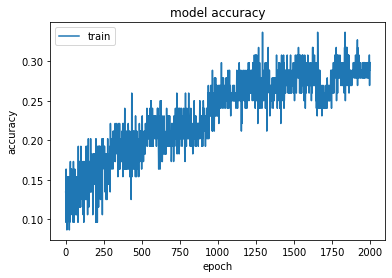

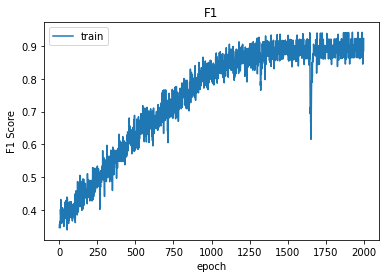

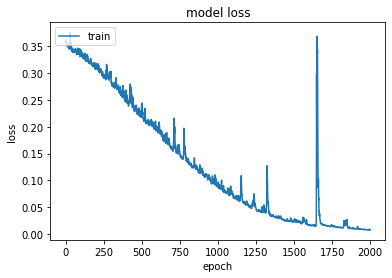

In [ ]:
history = model.fit(X_train, y_train, epochs=2000, verbose=0)
# Fit the model
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for f1
plt.plot(history.history['f1'])
plt.title('F1')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred_ori = model.predict(X_test)

In [ ]:
y_pred = np.where(y_pred_ori >= 0.2, 1, 0)

In [ ]:
f1(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.2823313>

In [ ]:
utils.confusion_matrix(y_true, y_pred)

Confusion Matrix
 [[200  60]
 [ 46  32]]
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.33      0.30      0.32        10
           2       0.40      0.50      0.44         8
           3       0.25      0.25      0.25         4
           4       0.00      0.00      0.00         1
           5       0.36      0.45      0.40        11
           6       0.29      0.67      0.40         6
           7       0.29      0.33      0.31         6
           8       0.00      0.00      0.00         0
           9       0.20      0.40      0.27         5
          10       0.00      0.00      0.00         1
          11       0.64      0.70      0.67        10
          12       0.60      0.23      0.33        13

   micro avg       0.35      0.41      0.38        78
   macro avg       0.28      0.32      0.28        78
weighted avg       0.39      0.41      0.38        78
 samples avg       0.34      0.41      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pltX = []
pltY = []

for name2,data2 in second.items():

    row = [name2]
    for name1,data1 in first.items():
        data = np.stack((data1, data2), axis=1)
        loss = K.eval(f1_loss(Y, data))
        f1 = f1_score(Y, data, average='macro')
        pltX.append(loss)
        pltY.append(f1)
        row.append('{:2f}\n{:2f}'.format(loss, f1))

NameError: ignored